In [20]:
import numpy as np
import random
import torch
import torch.nn as nn
import gym
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.patches as patches

class Qfunction(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.linear_1 = nn.Linear(state_dim, 64)
        self.linear_2 = nn.Linear(64, 64)
        self.linear_3 = nn.Linear(64, action_dim)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, states):
        hidden = self.linear_1(states)
        hidden = self.activation(hidden)
        hidden = self.linear_2(hidden)
        hidden = self.activation(hidden)
        actions = self.linear_3(hidden)
        return actions

In [21]:
%matplotlib notebook

In [3]:
class HDQN:
    def __init__(self, state_dim, action_dim, gamma=0.99, lr=1e-3, batch_size=128, epsilon_decrease=0.01, epsilon_min=0.03):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.q_function = Qfunction(self.state_dim, self.action_dim)
        self.q_function_ = Qfunction(self.state_dim, self.action_dim)
        self.q_function_.load_state_dict(self.q_function.state_dict())
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = 1
        self.epsilon_decrease = epsilon_decrease
        self.epsilon_min = epsilon_min
        self.memory = []
        self.memory_lim = 30000
        self.optimzaer = torch.optim.Adam(self.q_function.parameters(), lr=lr)

    def get_action(self, state):
        q_values = self.q_function(torch.FloatTensor(state))
        argmax_action = torch.argmax(q_values,dim=-1)
        probs = self.epsilon * np.ones((argmax_action.shape[0],self.action_dim)) / self.action_dim
        probs[np.arange(argmax_action.shape[0]),argmax_action] += 1 - self.epsilon
        action = np.ones(q_values.shape[0], dtype=np.int32)
        for sample in range(q_values.shape[0]):
            action[sample] = np.random.choice(np.arange(self.action_dim), p=probs[sample,:])
        return action
    
    def fit(self, state, action, reward, done, next_state, update_net = True):
        if(update_net):
            print('hard update')
            self.q_function_.load_state_dict(self.q_function.state_dict())
        self.memory.append([state, action, reward, int(done), next_state])
        #if(len(self.memory)>self.memory_lim):
            #self.memory = self.memory[len(self.memory)//2:]
            #print('clear memory')
        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.tensor, list(zip(*batch)))
    
            targets = rewards + self.gamma * (1 - dones) * torch.max(self.q_function_(next_states), dim=1).values
            q_values = self.q_function(states)[torch.arange(self.batch_size), actions]
            
            loss = torch.mean((q_values - targets.detach()) ** 2)
            loss.backward()
            self.optimzaer.step()
            self.optimzaer.zero_grad()
            
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decrease

In [4]:
env = gym.make('LunarLander-v2')

In [11]:
%%time
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

episode_n = 2000
t_max = 2000
do_clear = True

agent_h = HDQN(state_dim, action_dim,epsilon_decrease=0.1/episode_n)
hist_h = []

for episode in range(episode_n):
    total_reward = 0

    state = env.reset()
    for t in range(t_max):
        action = agent_h.get_action([state])
        next_state, reward, done, _ = env.step(action[0])

        total_reward += reward
        agent_h.fit(state, int(action), reward, done, next_state,update_net=(t == 0 and episode%20==0))

        state = next_state

        if done:
            break
    
    hist_h.append(total_reward)
        
    if(np.mean(hist_h[-100:])>220):
        break

    print(f'episode: {episode}, total_reward_last_100: {np.mean(hist_h[-100:])} {hist_h[-1]}, epsilon: {agent_h.epsilon}')

hard update
episode: 0, total_reward_last_100: -70.9465100363722 -70.9465100363722, epsilon: 1
episode: 1, total_reward_last_100: -259.9488612396042 -448.95121244283615, epsilon: 0.9984500000000002
episode: 2, total_reward_last_100: -222.3352960486669 -147.10816566679233, epsilon: 0.9922500000000009
episode: 3, total_reward_last_100: -161.67550099827366 20.303884152905965, epsilon: 0.9883000000000013
episode: 4, total_reward_last_100: -176.70740715835285 -236.8350317986697, epsilon: 0.9829500000000019
episode: 5, total_reward_last_100: -154.05621999944245 -40.8002842048904, epsilon: 0.9762000000000026
episode: 6, total_reward_last_100: -176.37486717390462 -310.2867502206774, epsilon: 0.9717500000000031
episode: 7, total_reward_last_100: -173.65784134446085 -154.63866053835466, epsilon: 0.9662500000000037
episode: 8, total_reward_last_100: -163.4766776261389 -82.0273678795633, epsilon: 0.9626500000000041
episode: 9, total_reward_last_100: -160.53947600137727 -134.1046613785225, epsilon:

episode: 79, total_reward_last_100: -148.44149629313762 -193.32679290704436, epsilon: 0.5705500000000473
hard update
episode: 80, total_reward_last_100: -148.95660636250417 -190.1654119118303, epsilon: 0.5627000000000482
episode: 81, total_reward_last_100: -149.18356822064334 -167.56747872991326, epsilon: 0.5557000000000489
episode: 82, total_reward_last_100: -149.29721597315543 -158.6163316791476, epsilon: 0.5496500000000496
episode: 83, total_reward_last_100: -149.1111900493747 -133.6710383755753, epsilon: 0.5418000000000505
episode: 84, total_reward_last_100: -148.04270625399613 -58.29006744219621, epsilon: 0.5344000000000513
episode: 85, total_reward_last_100: -147.8175446258198 -128.67880623083153, epsilon: 0.527600000000052
episode: 86, total_reward_last_100: -150.07390551519535 -344.1209420014933, epsilon: 0.5218500000000527
episode: 87, total_reward_last_100: -148.28097484537045 7.7039934293967605, epsilon: 0.5171500000000532
episode: 88, total_reward_last_100: -149.39619789958

episode: 157, total_reward_last_100: -140.68833058024637 -124.43972058098036, epsilon: 0.02995000000010232
episode: 158, total_reward_last_100: -141.01486979076188 -85.29482708693445, epsilon: 0.02995000000010232
episode: 159, total_reward_last_100: -141.81419458455494 -104.467518973129, epsilon: 0.02995000000010232
hard update
episode: 160, total_reward_last_100: -143.73172206326961 -248.59916445491788, epsilon: 0.02995000000010232
episode: 161, total_reward_last_100: -143.9909890985659 -133.15548940559867, epsilon: 0.02995000000010232
episode: 162, total_reward_last_100: -145.03427483811677 -87.5828676817286, epsilon: 0.02995000000010232
episode: 163, total_reward_last_100: -144.39568439473933 -61.64926811211764, epsilon: 0.02995000000010232
episode: 164, total_reward_last_100: -143.36833935855836 -34.22824951427975, epsilon: 0.02995000000010232
episode: 165, total_reward_last_100: -143.89557996853583 -117.0076160155787, epsilon: 0.02995000000010232
episode: 166, total_reward_last_10

episode: 234, total_reward_last_100: -124.80586178650107 -92.8963366324189, epsilon: 0.02995000000010232
episode: 235, total_reward_last_100: -124.46485230211394 -85.62958853242803, epsilon: 0.02995000000010232
episode: 236, total_reward_last_100: -124.62425228641045 -113.74268491871925, epsilon: 0.02995000000010232
episode: 237, total_reward_last_100: -124.82397185185762 -125.3794626275228, epsilon: 0.02995000000010232
episode: 238, total_reward_last_100: -125.37342394855924 -165.09624747902913, epsilon: 0.02995000000010232
episode: 239, total_reward_last_100: -126.10945870741831 -177.71099901701584, epsilon: 0.02995000000010232
hard update
episode: 240, total_reward_last_100: -126.39457476801226 -89.77635084249553, epsilon: 0.02995000000010232
episode: 241, total_reward_last_100: -126.60680039259643 -149.54153187310123, epsilon: 0.02995000000010232
episode: 242, total_reward_last_100: -127.63660592215969 -139.14324079314247, epsilon: 0.02995000000010232
episode: 243, total_reward_las

episode: 311, total_reward_last_100: -139.88613192966662 -141.2501754977047, epsilon: 0.02995000000010232
episode: 312, total_reward_last_100: -139.18605868386555 -59.94517231740178, epsilon: 0.02995000000010232
episode: 313, total_reward_last_100: -138.7674666357431 -83.15261419138035, epsilon: 0.02995000000010232
episode: 314, total_reward_last_100: -141.1411938020134 -302.040458607349, epsilon: 0.02995000000010232
episode: 315, total_reward_last_100: -140.87464125337053 -140.14381237417638, epsilon: 0.02995000000010232
episode: 316, total_reward_last_100: -140.94482133825895 -158.761659063911, epsilon: 0.02995000000010232
episode: 317, total_reward_last_100: -143.17881637012616 -322.63705683464303, epsilon: 0.02995000000010232
episode: 318, total_reward_last_100: -142.79527704098157 -63.586379572639856, epsilon: 0.02995000000010232
episode: 319, total_reward_last_100: -143.4941019713537 -163.238568096408, epsilon: 0.02995000000010232
hard update
episode: 320, total_reward_last_100: 

episode: 388, total_reward_last_100: -133.52696840020647 -147.24554949107085, epsilon: 0.02995000000010232
episode: 389, total_reward_last_100: -133.59634176591914 -161.59107813504178, epsilon: 0.02995000000010232
episode: 390, total_reward_last_100: -134.00138389940608 -193.41714830251107, epsilon: 0.02995000000010232
episode: 391, total_reward_last_100: -135.5242911225061 -231.99559604434842, epsilon: 0.02995000000010232
episode: 392, total_reward_last_100: -134.45851349169791 -60.87609907277765, epsilon: 0.02995000000010232
episode: 393, total_reward_last_100: -134.4068550011259 -77.19742733850717, epsilon: 0.02995000000010232
episode: 394, total_reward_last_100: -134.87481981926032 -146.70570482956677, epsilon: 0.02995000000010232
episode: 395, total_reward_last_100: -135.16752304545847 -173.966614349965, epsilon: 0.02995000000010232
episode: 396, total_reward_last_100: -135.14370795086728 -138.6887001810146, epsilon: 0.02995000000010232
episode: 397, total_reward_last_100: -135.26

episode: 465, total_reward_last_100: -128.28648043761225 -47.30584444794744, epsilon: 0.02995000000010232
episode: 466, total_reward_last_100: -127.65457324590156 -49.36405220318562, epsilon: 0.02995000000010232
episode: 467, total_reward_last_100: -127.38976835041208 -104.86813570673105, epsilon: 0.02995000000010232
episode: 468, total_reward_last_100: -126.47806367230673 -79.70152772569821, epsilon: 0.02995000000010232
episode: 469, total_reward_last_100: -127.30914848884642 -176.8925388020137, epsilon: 0.02995000000010232
episode: 470, total_reward_last_100: -126.99615857723697 -104.15389619148591, epsilon: 0.02995000000010232
episode: 471, total_reward_last_100: -128.0571494516158 -207.04076354962223, epsilon: 0.02995000000010232
episode: 472, total_reward_last_100: -128.15331795347902 -105.85746195842547, epsilon: 0.02995000000010232
episode: 473, total_reward_last_100: -128.37813099013545 -109.88260279558601, epsilon: 0.02995000000010232
episode: 474, total_reward_last_100: -128.

episode: 542, total_reward_last_100: -90.99212666734189 -67.29968497574922, epsilon: 0.02995000000010232
episode: 543, total_reward_last_100: -90.59695218745604 -48.209450227656426, epsilon: 0.02995000000010232
episode: 544, total_reward_last_100: -90.46077730498206 -81.81733068820348, epsilon: 0.02995000000010232
episode: 545, total_reward_last_100: -88.03639689864887 -121.52297722261966, epsilon: 0.02995000000010232
episode: 546, total_reward_last_100: -87.6560868720872 -75.90519604029818, epsilon: 0.02995000000010232
episode: 547, total_reward_last_100: -88.04880369785182 -121.88147650632396, epsilon: 0.02995000000010232
episode: 548, total_reward_last_100: -86.3827405374733 -92.20097610227388, epsilon: 0.02995000000010232
episode: 549, total_reward_last_100: -85.96977835593977 -89.71566791679155, epsilon: 0.02995000000010232
episode: 550, total_reward_last_100: -89.26292822969343 -80.48741798840935, epsilon: 0.02995000000010232
episode: 551, total_reward_last_100: -89.1365306275506

episode: 620, total_reward_last_100: -86.23532895534808 -20.359151542443854, epsilon: 0.02995000000010232
episode: 621, total_reward_last_100: -86.87148073006988 -109.26619148924135, epsilon: 0.02995000000010232
episode: 622, total_reward_last_100: -87.42883067717277 -83.52803155988383, epsilon: 0.02995000000010232
episode: 623, total_reward_last_100: -90.76616370834654 -397.8085721631278, epsilon: 0.02995000000010232
episode: 624, total_reward_last_100: -89.46325083778777 23.14446862751143, epsilon: 0.02995000000010232
episode: 625, total_reward_last_100: -89.02095249716913 -124.76800735379682, epsilon: 0.02995000000010232
episode: 626, total_reward_last_100: -89.20448222070829 -44.886024938636744, epsilon: 0.02995000000010232
episode: 627, total_reward_last_100: -89.49186990089608 -68.4025737323499, epsilon: 0.02995000000010232
episode: 628, total_reward_last_100: -90.24183158111845 -168.0290674930291, epsilon: 0.02995000000010232
episode: 629, total_reward_last_100: -90.832322933391

episode: 698, total_reward_last_100: -137.30628969958047 -169.12655273811336, epsilon: 0.02995000000010232
episode: 699, total_reward_last_100: -137.4451638052934 -45.592263809507806, epsilon: 0.02995000000010232
hard update
episode: 700, total_reward_last_100: -138.9848907935102 -196.2817796251747, epsilon: 0.02995000000010232
episode: 701, total_reward_last_100: -138.83183482670424 -40.19937051150502, epsilon: 0.02995000000010232
episode: 702, total_reward_last_100: -140.12581892143336 -200.77793792409958, epsilon: 0.02995000000010232
episode: 703, total_reward_last_100: -140.4291660334681 -126.08077005069322, epsilon: 0.02995000000010232
episode: 704, total_reward_last_100: -140.59508739231777 -81.26719043298039, epsilon: 0.02995000000010232
episode: 705, total_reward_last_100: -143.14466908995067 -315.9021440805296, epsilon: 0.02995000000010232
episode: 706, total_reward_last_100: -142.5751165002813 -168.02798586380572, epsilon: 0.02995000000010232
episode: 707, total_reward_last_1

episode: 775, total_reward_last_100: -169.9944260806186 -114.96217341440794, epsilon: 0.02995000000010232
episode: 776, total_reward_last_100: -167.4641972800314 -56.91695225687374, epsilon: 0.02995000000010232
episode: 777, total_reward_last_100: -170.03344815367555 -324.76216340754127, epsilon: 0.02995000000010232
episode: 778, total_reward_last_100: -168.8521579715201 -9.761515783105812, epsilon: 0.02995000000010232
episode: 779, total_reward_last_100: -168.70049053211724 -161.12704800628023, epsilon: 0.02995000000010232
hard update
episode: 780, total_reward_last_100: -173.1377940281679 -523.9988966272863, epsilon: 0.02995000000010232
episode: 781, total_reward_last_100: -173.2700021851467 -133.55347097679788, epsilon: 0.02995000000010232
episode: 782, total_reward_last_100: -172.62625286823288 -54.677100451015036, epsilon: 0.02995000000010232
episode: 783, total_reward_last_100: -172.2359139808649 -80.20554680468045, epsilon: 0.02995000000010232
episode: 784, total_reward_last_100

episode: 852, total_reward_last_100: -159.3751086713085 -258.26968130256773, epsilon: 0.02995000000010232
episode: 853, total_reward_last_100: -158.74585908649104 -109.51778430063524, epsilon: 0.02995000000010232
episode: 854, total_reward_last_100: -157.28413719216778 -38.7469790474899, epsilon: 0.02995000000010232
episode: 855, total_reward_last_100: -156.05094920597222 -67.13684277966038, epsilon: 0.02995000000010232
episode: 856, total_reward_last_100: -156.82589286820485 -64.44711725899177, epsilon: 0.02995000000010232
episode: 857, total_reward_last_100: -154.22273404468456 -31.6721280098094, epsilon: 0.02995000000010232
episode: 858, total_reward_last_100: -154.50478342680947 -278.6142793317409, epsilon: 0.02995000000010232
episode: 859, total_reward_last_100: -153.89363143798371 -59.14233481664837, epsilon: 0.02995000000010232
hard update
episode: 860, total_reward_last_100: -153.23776008913998 -96.5075365914284, epsilon: 0.02995000000010232
episode: 861, total_reward_last_100:

episode: 930, total_reward_last_100: -85.75822928733197 123.38153839219234, epsilon: 0.02995000000010232
episode: 931, total_reward_last_100: -86.00408459144717 -129.5667114055188, epsilon: 0.02995000000010232
episode: 932, total_reward_last_100: -84.17423213037145 -15.569416756110911, epsilon: 0.02995000000010232
episode: 933, total_reward_last_100: -86.45276430727695 -293.34911425809787, epsilon: 0.02995000000010232
episode: 934, total_reward_last_100: -88.82721552010292 -319.83915296555745, epsilon: 0.02995000000010232
episode: 935, total_reward_last_100: -89.10607078140434 -45.50787910972471, epsilon: 0.02995000000010232
episode: 936, total_reward_last_100: -87.25330254815213 -136.61523730151794, epsilon: 0.02995000000010232
episode: 937, total_reward_last_100: -88.94814101365505 -264.5410153198064, epsilon: 0.02995000000010232
episode: 938, total_reward_last_100: -89.81505563217374 -208.63783145281747, epsilon: 0.02995000000010232
episode: 939, total_reward_last_100: -88.272418182

episode: 1008, total_reward_last_100: -68.88213102715098 -171.04843690874824, epsilon: 0.02995000000010232
episode: 1009, total_reward_last_100: -68.00006821309385 -175.91540788163258, epsilon: 0.02995000000010232
episode: 1010, total_reward_last_100: -66.52586073669352 -134.95233595724494, epsilon: 0.02995000000010232
episode: 1011, total_reward_last_100: -71.26868933327151 -265.1170258712708, epsilon: 0.02995000000010232
episode: 1012, total_reward_last_100: -68.51369415515279 205.5286904265003, epsilon: 0.02995000000010232
episode: 1013, total_reward_last_100: -72.04600306417029 -347.74675203559354, epsilon: 0.02995000000010232
episode: 1014, total_reward_last_100: -71.30419458315907 79.406519518279, epsilon: 0.02995000000010232
episode: 1015, total_reward_last_100: -68.57302753368909 -119.76809430421825, epsilon: 0.02995000000010232
episode: 1016, total_reward_last_100: -70.36728770926818 -244.09709030477805, epsilon: 0.02995000000010232
episode: 1017, total_reward_last_100: -66.57

episode: 1085, total_reward_last_100: -36.988877642372685 210.6600777927157, epsilon: 0.02995000000010232
episode: 1086, total_reward_last_100: -37.460146021585764 -117.47661177370341, epsilon: 0.02995000000010232
episode: 1087, total_reward_last_100: -38.836133333351775 -131.2828439844238, epsilon: 0.02995000000010232
episode: 1088, total_reward_last_100: -35.24896856311543 268.4339441083297, epsilon: 0.02995000000010232
episode: 1089, total_reward_last_100: -32.45252677070522 211.98224573631109, epsilon: 0.02995000000010232
episode: 1090, total_reward_last_100: -33.06471930308934 -162.69062284527854, epsilon: 0.02995000000010232
episode: 1091, total_reward_last_100: -30.922470952210677 180.3917187602911, epsilon: 0.02995000000010232
episode: 1092, total_reward_last_100: -30.455457861625504 16.93084709833279, epsilon: 0.02995000000010232
episode: 1093, total_reward_last_100: -27.621234930075158 192.53078313788077, epsilon: 0.02995000000010232
episode: 1094, total_reward_last_100: -23.

episode: 1162, total_reward_last_100: -28.90388081051994 -249.36435403902595, epsilon: 0.02995000000010232
episode: 1163, total_reward_last_100: -29.988036290278142 -135.45076427948794, epsilon: 0.02995000000010232
episode: 1164, total_reward_last_100: -32.98371847907091 -73.98531903712768, epsilon: 0.02995000000010232
episode: 1165, total_reward_last_100: -33.74704992211804 -111.71359960831917, epsilon: 0.02995000000010232
episode: 1166, total_reward_last_100: -34.00906027105789 212.0454309075218, epsilon: 0.02995000000010232
episode: 1167, total_reward_last_100: -34.50028282212801 -142.50089123677873, epsilon: 0.02995000000010232
episode: 1168, total_reward_last_100: -34.41265254931941 -34.71806719886817, epsilon: 0.02995000000010232
episode: 1169, total_reward_last_100: -30.605496085555757 287.7196130712804, epsilon: 0.02995000000010232
episode: 1170, total_reward_last_100: -27.723851536487373 -105.12282414251325, epsilon: 0.02995000000010232
episode: 1171, total_reward_last_100: -3

episode: 1239, total_reward_last_100: -15.613891169141443 189.39771804528732, epsilon: 0.02995000000010232
hard update
episode: 1240, total_reward_last_100: -14.858674296199453 -39.749433497758005, epsilon: 0.02995000000010232
episode: 1241, total_reward_last_100: -18.4178352452575 -155.51063225824151, epsilon: 0.02995000000010232
episode: 1242, total_reward_last_100: -14.489018719880002 224.20903365135678, epsilon: 0.02995000000010232
episode: 1243, total_reward_last_100: -15.361116209817174 -196.20351352782373, epsilon: 0.02995000000010232
episode: 1244, total_reward_last_100: -18.023125652010854 -25.381947149487388, epsilon: 0.02995000000010232
episode: 1245, total_reward_last_100: -20.574641738404736 -134.3532885726088, epsilon: 0.02995000000010232
episode: 1246, total_reward_last_100: -21.29210252384325 -98.2057198161701, epsilon: 0.02995000000010232
episode: 1247, total_reward_last_100: -17.83940944823117 243.43465777296004, epsilon: 0.02995000000010232
episode: 1248, total_rewar

episode: 1316, total_reward_last_100: 5.966786008211743 163.5944500790931, epsilon: 0.02995000000010232
episode: 1317, total_reward_last_100: 5.915787358252785 203.2736153255799, epsilon: 0.02995000000010232
episode: 1318, total_reward_last_100: 10.253111680196406 264.255456738948, epsilon: 0.02995000000010232
episode: 1319, total_reward_last_100: 7.700978779427297 -48.14115919002725, epsilon: 0.02995000000010232
hard update
episode: 1320, total_reward_last_100: 12.498980925910605 235.68838787757778, epsilon: 0.02995000000010232
episode: 1321, total_reward_last_100: 15.23159239624448 253.82356807054765, epsilon: 0.02995000000010232
episode: 1322, total_reward_last_100: 20.297912400349613 234.737948960451, epsilon: 0.02995000000010232
episode: 1323, total_reward_last_100: 17.561712141770926 -55.15247784552107, epsilon: 0.02995000000010232
episode: 1324, total_reward_last_100: 19.24537900352615 173.41147260986332, epsilon: 0.02995000000010232
episode: 1325, total_reward_last_100: 22.1823

episode: 1395, total_reward_last_100: 101.94265917238751 220.77237194911135, epsilon: 0.02995000000010232
episode: 1396, total_reward_last_100: 108.96200765462046 209.97640306459493, epsilon: 0.02995000000010232
episode: 1397, total_reward_last_100: 108.60980713786094 204.7885462128292, epsilon: 0.02995000000010232
episode: 1398, total_reward_last_100: 112.78928536738853 194.2769924035832, epsilon: 0.02995000000010232
episode: 1399, total_reward_last_100: 115.66281344922402 251.12517605490584, epsilon: 0.02995000000010232
hard update
episode: 1400, total_reward_last_100: 120.70349961122598 208.2363534443076, epsilon: 0.02995000000010232
episode: 1401, total_reward_last_100: 121.58458329807354 -115.24948926295252, epsilon: 0.02995000000010232
episode: 1402, total_reward_last_100: 122.06632328264868 217.1041355178618, epsilon: 0.02995000000010232
episode: 1403, total_reward_last_100: 122.66898431254107 240.4458190532776, epsilon: 0.02995000000010232
episode: 1404, total_reward_last_100: 

episode: 1473, total_reward_last_100: 72.02933404131639 -354.12931572321065, epsilon: 0.02995000000010232
episode: 1474, total_reward_last_100: 73.44901679879767 -3.586809803521362, epsilon: 0.02995000000010232
episode: 1475, total_reward_last_100: 72.71444003456747 108.13341789703591, epsilon: 0.02995000000010232
episode: 1476, total_reward_last_100: 69.31800280555562 -138.8261552479441, epsilon: 0.02995000000010232
episode: 1477, total_reward_last_100: 71.89080937635457 215.05795719052406, epsilon: 0.02995000000010232
episode: 1478, total_reward_last_100: 73.17532575119236 203.39968469450298, epsilon: 0.02995000000010232
episode: 1479, total_reward_last_100: 74.2819435966944 267.8394224442549, epsilon: 0.02995000000010232
hard update
episode: 1480, total_reward_last_100: 74.03396430558068 189.82388867961518, epsilon: 0.02995000000010232
episode: 1481, total_reward_last_100: 70.37263125932913 -126.50351456927694, epsilon: 0.02995000000010232
episode: 1482, total_reward_last_100: 70.37

episode: 1551, total_reward_last_100: 77.90824046415051 238.11288319283966, epsilon: 0.02995000000010232
episode: 1552, total_reward_last_100: 77.7968709844094 237.50256659901936, epsilon: 0.02995000000010232
episode: 1553, total_reward_last_100: 77.40824827338051 -25.434750018757995, epsilon: 0.02995000000010232
episode: 1554, total_reward_last_100: 76.71482933466467 195.60839193088754, epsilon: 0.02995000000010232
episode: 1555, total_reward_last_100: 76.8316973901988 281.63453555262197, epsilon: 0.02995000000010232
episode: 1556, total_reward_last_100: 80.91627867835919 189.12687181738295, epsilon: 0.02995000000010232
episode: 1557, total_reward_last_100: 76.15556671778754 -338.37338200623697, epsilon: 0.02995000000010232
episode: 1558, total_reward_last_100: 73.37213257936932 -7.497545428440461, epsilon: 0.02995000000010232
episode: 1559, total_reward_last_100: 73.13045305521933 218.6155859057851, epsilon: 0.02995000000010232
hard update
episode: 1560, total_reward_last_100: 73.078

episode: 1629, total_reward_last_100: 92.9935549391445 -252.39259123248723, epsilon: 0.02995000000010232
episode: 1630, total_reward_last_100: 91.8944321475412 -170.6172900372681, epsilon: 0.02995000000010232
episode: 1631, total_reward_last_100: 92.32604528484036 -70.70273106031999, epsilon: 0.02995000000010232
episode: 1632, total_reward_last_100: 87.8387553420211 -218.050414350629, epsilon: 0.02995000000010232
episode: 1633, total_reward_last_100: 88.46153162401033 -177.42502384181455, epsilon: 0.02995000000010232
episode: 1634, total_reward_last_100: 87.61676243608626 -166.41672122212668, epsilon: 0.02995000000010232
episode: 1635, total_reward_last_100: 91.41064899394684 229.68498484574806, epsilon: 0.02995000000010232
episode: 1636, total_reward_last_100: 88.49148472523775 -39.51701506117773, epsilon: 0.02995000000010232
episode: 1637, total_reward_last_100: 86.68417628312186 -27.438499268224945, epsilon: 0.02995000000010232
episode: 1638, total_reward_last_100: 86.14838948678484

episode: 1707, total_reward_last_100: -16.81541557715888 217.60895762958813, epsilon: 0.02995000000010232
episode: 1708, total_reward_last_100: -20.776580697512102 -142.7194131593803, epsilon: 0.02995000000010232
episode: 1709, total_reward_last_100: -22.53254864053783 15.326377038194735, epsilon: 0.02995000000010232
episode: 1710, total_reward_last_100: -23.238797765791606 -139.35136789516113, epsilon: 0.02995000000010232
episode: 1711, total_reward_last_100: -22.677391462584715 231.01532326116296, epsilon: 0.02995000000010232
episode: 1712, total_reward_last_100: -23.60814189941961 160.38396339863056, epsilon: 0.02995000000010232
episode: 1713, total_reward_last_100: -23.40036617741397 225.25873163778022, epsilon: 0.02995000000010232
episode: 1714, total_reward_last_100: -26.12230057063263 -106.83052816371911, epsilon: 0.02995000000010232
episode: 1715, total_reward_last_100: -21.59819696664551 123.65180460169782, epsilon: 0.02995000000010232
episode: 1716, total_reward_last_100: -22

episode: 1784, total_reward_last_100: -41.25331807643072 -115.62515130471922, epsilon: 0.02995000000010232
episode: 1785, total_reward_last_100: -44.02479482052352 -436.92469538054473, epsilon: 0.02995000000010232
episode: 1786, total_reward_last_100: -43.72120017957302 -66.04634400976019, epsilon: 0.02995000000010232
episode: 1787, total_reward_last_100: -43.95634660587945 -142.1074611887663, epsilon: 0.02995000000010232
episode: 1788, total_reward_last_100: -44.73654522562697 -168.40801659318748, epsilon: 0.02995000000010232
episode: 1789, total_reward_last_100: -45.77533363248255 -217.33314904149864, epsilon: 0.02995000000010232
episode: 1790, total_reward_last_100: -45.51852983907572 -84.5091944030286, epsilon: 0.02995000000010232
episode: 1791, total_reward_last_100: -47.79876369019487 -284.1737255401771, epsilon: 0.02995000000010232
episode: 1792, total_reward_last_100: -47.6345975153178 -160.16918281939348, epsilon: 0.02995000000010232
episode: 1793, total_reward_last_100: -48.2

episode: 1861, total_reward_last_100: -48.909013693246486 -88.98961383070758, epsilon: 0.02995000000010232
episode: 1862, total_reward_last_100: -50.39759739040719 -189.26923440641295, epsilon: 0.02995000000010232
episode: 1863, total_reward_last_100: -48.623220512170676 159.71592937340102, epsilon: 0.02995000000010232
episode: 1864, total_reward_last_100: -50.10916464901472 -221.38806410438093, epsilon: 0.02995000000010232
episode: 1865, total_reward_last_100: -46.276242152656074 211.92337968510228, epsilon: 0.02995000000010232
episode: 1866, total_reward_last_100: -41.35674989541387 210.8408961765076, epsilon: 0.02995000000010232
episode: 1867, total_reward_last_100: -44.75420341434644 -177.1114809858113, epsilon: 0.02995000000010232
episode: 1868, total_reward_last_100: -47.226222133982795 -64.05947754039568, epsilon: 0.02995000000010232
episode: 1869, total_reward_last_100: -48.328692791877565 -169.26286905904988, epsilon: 0.02995000000010232
episode: 1870, total_reward_last_100: -

episode: 1938, total_reward_last_100: 23.440805797767084 266.40304898539813, epsilon: 0.02995000000010232
episode: 1939, total_reward_last_100: 19.347897316589812 -154.71854793776492, epsilon: 0.02995000000010232
hard update
episode: 1940, total_reward_last_100: 18.836303161841215 -152.00069608056452, epsilon: 0.02995000000010232
episode: 1941, total_reward_last_100: 17.017037097096775 -120.69499862597951, epsilon: 0.02995000000010232
episode: 1942, total_reward_last_100: 15.11693950827111 -275.1606173134267, epsilon: 0.02995000000010232
episode: 1943, total_reward_last_100: 15.627870721367707 -115.79606141337877, epsilon: 0.02995000000010232
episode: 1944, total_reward_last_100: 15.298537908904963 -107.77072864610375, epsilon: 0.02995000000010232
episode: 1945, total_reward_last_100: 13.643270520551944 -221.69002092304186, epsilon: 0.02995000000010232
episode: 1946, total_reward_last_100: 14.04188434833326 125.56596845287298, epsilon: 0.02995000000010232
episode: 1947, total_reward_la

In [36]:
#env = gym.make('LunarLander-v2')
agent_h.epsilon = 0
total_reward = 0
state = env.reset()
for t in range(t_max):
    action = agent_h.get_action([state])
    next_state, reward, done, _ = env.step(action[0])
    env.render()
    total_reward += reward
    state = next_state
    if done:
        break
print(total_reward)

-165.60246600712213


In [12]:
class SDQN:
    def __init__(self, state_dim, action_dim, gamma=0.993, lr=1e-3, batch_size=128, epsilon_decrease=0.01, epsilon_min=0.03):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.q_function = Qfunction(self.state_dim, self.action_dim)
        self.q_function_ = Qfunction(self.state_dim, self.action_dim)
        for target_param in self.q_function_.parameters():
            target_param.data.copy_(target_param.data*0)
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = 1
        self.epsilon_decrease = epsilon_decrease
        self.epsilon_min = epsilon_min
        self.memory = []
        self.memory_lim = 150000
        self.optimzaer = torch.optim.Adam(self.q_function.parameters(), lr=lr)

    def get_action(self, state, target= False):
        if(target):
            q_values = self.q_function_(torch.FloatTensor(state))
        else:
            q_values = self.q_function(torch.FloatTensor(state))
        argmax_action = torch.argmax(q_values,dim=-1)
        probs = self.epsilon * np.ones((argmax_action.shape[0],self.action_dim)) / self.action_dim
        probs[np.arange(argmax_action.shape[0]),argmax_action] += 1 - self.epsilon
        action = np.ones(q_values.shape[0], dtype=np.int32)
        for sample in range(q_values.shape[0]):
            action[sample] = np.random.choice(np.arange(self.action_dim), p=probs[sample,:])
        return action
    
    def fit(self, state, action, reward, done, next_state, tau):
        self.memory.append([state, action, reward, int(done), next_state])
        if(len(self.memory)>self.memory_lim):
            self.memory = self.memory[int(self.memory_lim*0.05):]
            self.memory = random.sample(self.memory, int(self.memory_lim*0.9))
            print('clear memory')
        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.tensor, list(zip(*batch)))
    
            targets = rewards + self.gamma * (1 - dones) * torch.max(self.q_function_(next_states), dim=1).values
            q_values = self.q_function(states)[torch.arange(self.batch_size), actions]
            
            loss = torch.mean((q_values - targets.detach()) ** 2)
            loss.backward()
            self.optimzaer.step()
            self.optimzaer.zero_grad()
            
            self.soft_update(self.q_function,self.q_function_, tau)
            
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decrease
                
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [13]:
%%time
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

episode_n = 2000
t_max = 500
do_clear = True

agent_s = SDQN(state_dim, action_dim,epsilon_decrease=0.03/episode_n)
hist_s = []
hist_s_v = []
hist_s_v_disc = []
hist_s_v_ = []
hist_s_v_disc_ = []

for episode in range(episode_n):
    total_reward = 0

    state = env.reset()
    for t in range(t_max):
        action = agent_s.get_action([state])
        next_state, reward, done, _ = env.step(action[0])

        total_reward += reward
        agent_s.fit(state, int(action), reward, done, next_state,tau = 0.005)

        state = next_state

        if done:
            break
    
    hist_s.append(total_reward)
    
    #validate
    if(episode%10 == 0):
        eps = agent_s.epsilon
        agent_s.epsilon = 0
        total_reward = 0
        total_reward_disc = 0
        rew_mult = 1
        state = env.reset()
        for t in range(t_max):
            action = agent_s.get_action([state], True)
            next_state, reward, done, _ = env.step(action[0])

            total_reward += reward
            
            total_reward_disc += rew_mult*reward
            rew_mult *= agent_s.gamma

            state = next_state

            if done:
                break
        agent_s.epsilon = eps
        
        hist_s_v_.append(total_reward)
        hist_s_v_disc_.append(total_reward_disc)
        
    
    if(episode%10 == 0):
        eps = agent_s.epsilon
        agent_s.epsilon = 0
        total_reward = 0
        total_reward_disc = 0
        rew_mult = 1
        state = env.reset()
        for t in range(t_max):
            action = agent_s.get_action([state], False)
            next_state, reward, done, _ = env.step(action[0])

            total_reward += reward
            
            total_reward_disc += rew_mult*reward
            rew_mult *= agent_s.gamma

            state = next_state

            if done:
                break
        agent_s.epsilon = eps
        
        hist_s_v.append(total_reward)
        hist_s_v_disc.append(total_reward_disc)
        
    if(np.mean(hist_s_v[-10:])>220):
        break

    print(f'episode: {episode}, \
rew: {round(np.mean(hist_s[-100:]),2)}, \
v_: {round(np.mean(hist_s_v_[-10:]),2)}, \
v_disc_: {round(np.mean(hist_s_v_disc_[-10:]),2)}, \
v: {round(np.mean(hist_s_v[-10:]),2)}, \
v_disc: {round(np.mean(hist_s_v_disc[-10:]),2)}, \
epsilon: {round(agent_s.epsilon,2)}, \
mem: {len(agent_s.memory)}')

episode: 0, rew: -130.55, v_: -119.61, v_disc_: -89.87, v: -1029.18, v_disc: -695.47, epsilon: 1, mem: 106
episode: 1, rew: -132.62, v_: -119.61, v_disc_: -89.87, v: -1029.18, v_disc: -695.47, epsilon: 1.0, mem: 170
episode: 2, rew: -136.61, v_: -119.61, v_disc_: -89.87, v: -1029.18, v_disc: -695.47, epsilon: 1.0, mem: 269
episode: 3, rew: -141.89, v_: -119.61, v_disc_: -89.87, v: -1029.18, v_disc: -695.47, epsilon: 1.0, mem: 347
episode: 4, rew: -130.27, v_: -119.61, v_disc_: -89.87, v: -1029.18, v_disc: -695.47, epsilon: 1.0, mem: 420
episode: 5, rew: -134.39, v_: -119.61, v_disc_: -89.87, v: -1029.18, v_disc: -695.47, epsilon: 0.99, mem: 499
episode: 6, rew: -139.22, v_: -119.61, v_disc_: -89.87, v: -1029.18, v_disc: -695.47, epsilon: 0.99, mem: 571
episode: 7, rew: -167.77, v_: -119.61, v_disc_: -89.87, v: -1029.18, v_disc: -695.47, epsilon: 0.99, mem: 688
episode: 8, rew: -159.83, v_: -119.61, v_disc_: -89.87, v: -1029.18, v_disc: -695.47, epsilon: 0.99, mem: 761
episode: 9, rew: 

episode: 74, rew: -146.82, v_: -256.14, v_disc_: -119.21, v: -364.05, v_disc: -177.65, epsilon: 0.9, mem: 6615
episode: 75, rew: -146.33, v_: -256.14, v_disc_: -119.21, v: -364.05, v_disc: -177.65, epsilon: 0.9, mem: 6739
episode: 76, rew: -146.56, v_: -256.14, v_disc_: -119.21, v: -364.05, v_disc: -177.65, epsilon: 0.9, mem: 6844
episode: 77, rew: -144.39, v_: -256.14, v_disc_: -119.21, v: -364.05, v_disc: -177.65, epsilon: 0.9, mem: 6980
episode: 78, rew: -144.57, v_: -256.14, v_disc_: -119.21, v: -364.05, v_disc: -177.65, epsilon: 0.9, mem: 7048
episode: 79, rew: -143.61, v_: -256.14, v_disc_: -119.21, v: -364.05, v_disc: -177.65, epsilon: 0.89, mem: 7168
episode: 80, rew: -143.0, v_: -246.01, v_disc_: -103.59, v: -337.48, v_disc: -155.33, epsilon: 0.89, mem: 7253
episode: 81, rew: -142.32, v_: -246.01, v_disc_: -103.59, v: -337.48, v_disc: -155.33, epsilon: 0.89, mem: 7315
episode: 82, rew: -146.18, v_: -246.01, v_disc_: -103.59, v: -337.48, v_disc: -155.33, epsilon: 0.89, mem: 741

episode: 148, rew: -128.56, v_: -131.66, v_disc_: 2.59, v: -131.87, v_disc: -9.28, epsilon: 0.79, mem: 13830
episode: 149, rew: -127.49, v_: -131.66, v_disc_: 2.59, v: -131.87, v_disc: -9.28, epsilon: 0.79, mem: 13921
episode: 150, rew: -126.87, v_: -126.75, v_disc_: 4.95, v: -113.11, v_disc: 6.16, epsilon: 0.79, mem: 14022
episode: 151, rew: -126.03, v_: -126.75, v_disc_: 4.95, v: -113.11, v_disc: 6.16, epsilon: 0.79, mem: 14111
episode: 152, rew: -125.43, v_: -126.75, v_disc_: 4.95, v: -113.11, v_disc: 6.16, epsilon: 0.79, mem: 14185
episode: 153, rew: -124.44, v_: -126.75, v_disc_: 4.95, v: -113.11, v_disc: 6.16, epsilon: 0.79, mem: 14305
episode: 154, rew: -121.12, v_: -126.75, v_disc_: 4.95, v: -113.11, v_disc: 6.16, epsilon: 0.79, mem: 14403
episode: 155, rew: -121.01, v_: -126.75, v_disc_: 4.95, v: -113.11, v_disc: 6.16, epsilon: 0.78, mem: 14494
episode: 156, rew: -120.61, v_: -126.75, v_disc_: 4.95, v: -113.11, v_disc: 6.16, epsilon: 0.78, mem: 14584
episode: 157, rew: -120.77

episode: 225, rew: -77.53, v_: -163.88, v_disc_: -4.84, v: -170.4, v_disc: -23.89, epsilon: 0.67, mem: 22179
episode: 226, rew: -76.96, v_: -163.88, v_disc_: -4.84, v: -170.4, v_disc: -23.89, epsilon: 0.67, mem: 22293
episode: 227, rew: -77.07, v_: -163.88, v_disc_: -4.84, v: -170.4, v_disc: -23.89, epsilon: 0.67, mem: 22397
episode: 228, rew: -76.76, v_: -163.88, v_disc_: -4.84, v: -170.4, v_disc: -23.89, epsilon: 0.66, mem: 22549
episode: 229, rew: -76.58, v_: -163.88, v_disc_: -4.84, v: -170.4, v_disc: -23.89, epsilon: 0.66, mem: 22620
episode: 230, rew: -76.24, v_: -173.16, v_disc_: -14.54, v: -171.1, v_disc: -30.61, epsilon: 0.66, mem: 22747
episode: 231, rew: -76.08, v_: -173.16, v_disc_: -14.54, v: -171.1, v_disc: -30.61, epsilon: 0.66, mem: 22910
episode: 232, rew: -76.47, v_: -173.16, v_disc_: -14.54, v: -171.1, v_disc: -30.61, epsilon: 0.66, mem: 23040
episode: 233, rew: -76.1, v_: -173.16, v_disc_: -14.54, v: -171.1, v_disc: -30.61, epsilon: 0.65, mem: 23188
episode: 234, re

episode: 300, rew: -67.41, v_: -158.02, v_disc_: -25.1, v: -236.13, v_disc: -51.66, epsilon: 0.51, mem: 33038
episode: 301, rew: -67.05, v_: -158.02, v_disc_: -25.1, v: -236.13, v_disc: -51.66, epsilon: 0.5, mem: 33404
episode: 302, rew: -66.55, v_: -158.02, v_disc_: -25.1, v: -236.13, v_disc: -51.66, epsilon: 0.5, mem: 33550
episode: 303, rew: -65.44, v_: -158.02, v_disc_: -25.1, v: -236.13, v_disc: -51.66, epsilon: 0.5, mem: 33638
episode: 304, rew: -66.29, v_: -158.02, v_disc_: -25.1, v: -236.13, v_disc: -51.66, epsilon: 0.49, mem: 33804
episode: 305, rew: -65.69, v_: -158.02, v_disc_: -25.1, v: -236.13, v_disc: -51.66, epsilon: 0.49, mem: 34304
episode: 306, rew: -65.23, v_: -158.02, v_disc_: -25.1, v: -236.13, v_disc: -51.66, epsilon: 0.48, mem: 34562
episode: 307, rew: -65.17, v_: -158.02, v_disc_: -25.1, v: -236.13, v_disc: -51.66, epsilon: 0.48, mem: 34673
episode: 308, rew: -65.78, v_: -158.02, v_disc_: -25.1, v: -236.13, v_disc: -51.66, epsilon: 0.48, mem: 34932
episode: 309,

episode: 376, rew: -17.56, v_: -4.98, v_disc_: 37.9, v: -84.08, v_disc: 24.61, epsilon: 0.06, mem: 62773
episode: 377, rew: -19.29, v_: -4.98, v_disc_: 37.9, v: -84.08, v_disc: 24.61, epsilon: 0.05, mem: 63268
episode: 378, rew: -18.25, v_: -4.98, v_disc_: 37.9, v: -84.08, v_disc: 24.61, epsilon: 0.05, mem: 63768
episode: 379, rew: -15.83, v_: -4.98, v_disc_: 37.9, v: -84.08, v_disc: 24.61, epsilon: 0.04, mem: 64268
episode: 380, rew: -14.05, v_: 25.53, v_disc_: 48.0, v: -55.58, v_disc: 29.9, epsilon: 0.03, mem: 64768
episode: 381, rew: -13.94, v_: 25.53, v_disc_: 48.0, v: -55.58, v_disc: 29.9, epsilon: 0.03, mem: 65268
episode: 382, rew: -12.22, v_: 25.53, v_disc_: 48.0, v: -55.58, v_disc: 29.9, epsilon: 0.03, mem: 65768
episode: 383, rew: -10.65, v_: 25.53, v_disc_: 48.0, v: -55.58, v_disc: 29.9, epsilon: 0.03, mem: 66268
episode: 384, rew: -9.46, v_: 25.53, v_disc_: 48.0, v: -55.58, v_disc: 29.9, epsilon: 0.03, mem: 66768
episode: 385, rew: -8.69, v_: 25.53, v_disc_: 48.0, v: -55.58

episode: 456, rew: 34.68, v_: 61.79, v_disc_: 57.82, v: 44.8, v_disc: 45.32, epsilon: 0.03, mem: 101480
episode: 457, rew: 36.3, v_: 61.79, v_disc_: 57.82, v: 44.8, v_disc: 45.32, epsilon: 0.03, mem: 101980
episode: 458, rew: 36.36, v_: 61.79, v_disc_: 57.82, v: 44.8, v_disc: 45.32, epsilon: 0.03, mem: 102480
episode: 459, rew: 37.62, v_: 61.79, v_disc_: 57.82, v: 44.8, v_disc: 45.32, epsilon: 0.03, mem: 102980
episode: 460, rew: 39.09, v_: 63.07, v_disc_: 58.55, v: 38.63, v_disc: 41.91, epsilon: 0.03, mem: 103480
episode: 461, rew: 39.93, v_: 63.07, v_disc_: 58.55, v: 38.63, v_disc: 41.91, epsilon: 0.03, mem: 103980
episode: 462, rew: 39.85, v_: 63.07, v_disc_: 58.55, v: 38.63, v_disc: 41.91, epsilon: 0.03, mem: 104480
episode: 463, rew: 39.42, v_: 63.07, v_disc_: 58.55, v: 38.63, v_disc: 41.91, epsilon: 0.03, mem: 104980
episode: 464, rew: 38.97, v_: 63.07, v_disc_: 58.55, v: 38.63, v_disc: 41.91, epsilon: 0.03, mem: 105480
episode: 465, rew: 38.91, v_: 63.07, v_disc_: 58.55, v: 38.6

episode: 535, rew: 30.56, v_: 50.28, v_disc_: 60.46, v: 37.68, v_disc: 47.86, epsilon: 0.03, mem: 140629
episode: 536, rew: 30.18, v_: 50.28, v_disc_: 60.46, v: 37.68, v_disc: 47.86, epsilon: 0.03, mem: 141129
episode: 537, rew: 29.77, v_: 50.28, v_disc_: 60.46, v: 37.68, v_disc: 47.86, epsilon: 0.03, mem: 141629
episode: 538, rew: 29.36, v_: 50.28, v_disc_: 60.46, v: 37.68, v_disc: 47.86, epsilon: 0.03, mem: 142129
episode: 539, rew: 29.62, v_: 50.28, v_disc_: 60.46, v: 37.68, v_disc: 47.86, epsilon: 0.03, mem: 142629
episode: 540, rew: 27.46, v_: 50.04, v_disc_: 58.62, v: 35.1, v_disc: 51.44, epsilon: 0.03, mem: 143085
episode: 541, rew: 27.18, v_: 50.04, v_disc_: 58.62, v: 35.1, v_disc: 51.44, epsilon: 0.03, mem: 143585
episode: 542, rew: 27.05, v_: 50.04, v_disc_: 58.62, v: 35.1, v_disc: 51.44, epsilon: 0.03, mem: 144085
episode: 543, rew: 26.93, v_: 50.04, v_disc_: 58.62, v: 35.1, v_disc: 51.44, epsilon: 0.03, mem: 144585
episode: 544, rew: 26.56, v_: 50.04, v_disc_: 58.62, v: 35.

episode: 614, rew: 54.89, v_: 68.34, v_disc_: 56.32, v: 59.0, v_disc: 57.6, epsilon: 0.03, mem: 149508
clear memory
episode: 615, rew: 56.17, v_: 68.34, v_disc_: 56.32, v: 59.0, v_disc: 57.6, epsilon: 0.03, mem: 135007
episode: 616, rew: 56.07, v_: 68.34, v_disc_: 56.32, v: 59.0, v_disc: 57.6, epsilon: 0.03, mem: 135507
episode: 617, rew: 56.73, v_: 68.34, v_disc_: 56.32, v: 59.0, v_disc: 57.6, epsilon: 0.03, mem: 136007
episode: 618, rew: 56.84, v_: 68.34, v_disc_: 56.32, v: 59.0, v_disc: 57.6, epsilon: 0.03, mem: 136507
episode: 619, rew: 56.91, v_: 68.34, v_disc_: 56.32, v: 59.0, v_disc: 57.6, epsilon: 0.03, mem: 137007
episode: 620, rew: 56.85, v_: 72.58, v_disc_: 57.72, v: 56.14, v_disc: 50.6, epsilon: 0.03, mem: 137507
episode: 621, rew: 57.74, v_: 72.58, v_disc_: 57.72, v: 56.14, v_disc: 50.6, epsilon: 0.03, mem: 138007
episode: 622, rew: 57.75, v_: 72.58, v_disc_: 57.72, v: 56.14, v_disc: 50.6, epsilon: 0.03, mem: 138507
episode: 623, rew: 56.29, v_: 72.58, v_disc_: 57.72, v: 5

episode: 693, rew: 72.73, v_: 84.12, v_disc_: 54.14, v: 47.82, v_disc: 23.7, epsilon: 0.03, mem: 141924
episode: 694, rew: 74.04, v_: 84.12, v_disc_: 54.14, v: 47.82, v_disc: 23.7, epsilon: 0.03, mem: 142258
episode: 695, rew: 74.07, v_: 84.12, v_disc_: 54.14, v: 47.82, v_disc: 23.7, epsilon: 0.03, mem: 142758
episode: 696, rew: 74.58, v_: 84.12, v_disc_: 54.14, v: 47.82, v_disc: 23.7, epsilon: 0.03, mem: 143258
episode: 697, rew: 75.35, v_: 84.12, v_disc_: 54.14, v: 47.82, v_disc: 23.7, epsilon: 0.03, mem: 143758
episode: 698, rew: 78.68, v_: 84.12, v_disc_: 54.14, v: 47.82, v_disc: 23.7, epsilon: 0.03, mem: 144258
episode: 699, rew: 76.03, v_: 84.12, v_disc_: 54.14, v: 47.82, v_disc: 23.7, epsilon: 0.03, mem: 144409
episode: 700, rew: 77.42, v_: 91.31, v_disc_: 56.39, v: 54.99, v_disc: 24.91, epsilon: 0.03, mem: 144873
episode: 701, rew: 77.9, v_: 91.31, v_disc_: 56.39, v: 54.99, v_disc: 24.91, epsilon: 0.03, mem: 145373
episode: 702, rew: 78.63, v_: 91.31, v_disc_: 56.39, v: 54.99, 

episode: 770, rew: 142.26, v_: 160.26, v_disc_: 73.67, v: 135.55, v_disc: 55.12, epsilon: 0.03, mem: 144026
episode: 771, rew: 141.05, v_: 160.26, v_disc_: 73.67, v: 135.55, v_disc: 55.12, epsilon: 0.03, mem: 144526
episode: 772, rew: 141.72, v_: 160.26, v_disc_: 73.67, v: 135.55, v_disc: 55.12, epsilon: 0.03, mem: 144807
episode: 773, rew: 140.76, v_: 160.26, v_disc_: 73.67, v: 135.55, v_disc: 55.12, epsilon: 0.03, mem: 145307
episode: 774, rew: 140.49, v_: 160.26, v_disc_: 73.67, v: 135.55, v_disc: 55.12, epsilon: 0.03, mem: 145684
episode: 775, rew: 141.31, v_: 160.26, v_disc_: 73.67, v: 135.55, v_disc: 55.12, epsilon: 0.03, mem: 146177
episode: 776, rew: 141.44, v_: 160.26, v_disc_: 73.67, v: 135.55, v_disc: 55.12, epsilon: 0.03, mem: 146677
episode: 777, rew: 140.27, v_: 160.26, v_disc_: 73.67, v: 135.55, v_disc: 55.12, epsilon: 0.03, mem: 146884
episode: 778, rew: 142.11, v_: 160.26, v_disc_: 73.67, v: 135.55, v_disc: 55.12, epsilon: 0.03, mem: 147356
episode: 779, rew: 143.78, v

episode: 846, rew: 168.86, v_: 200.76, v_disc_: 80.24, v: 146.9, v_disc: 68.19, epsilon: 0.03, mem: 139531
episode: 847, rew: 170.05, v_: 200.76, v_disc_: 80.24, v: 146.9, v_disc: 68.19, epsilon: 0.03, mem: 139897
episode: 848, rew: 171.12, v_: 200.76, v_disc_: 80.24, v: 146.9, v_disc: 68.19, epsilon: 0.03, mem: 140196
episode: 849, rew: 172.95, v_: 200.76, v_disc_: 80.24, v: 146.9, v_disc: 68.19, epsilon: 0.03, mem: 140430
episode: 850, rew: 172.69, v_: 206.22, v_disc_: 82.04, v: 97.27, v_disc: 53.3, epsilon: 0.03, mem: 140748
episode: 851, rew: 174.62, v_: 206.22, v_disc_: 82.04, v: 97.27, v_disc: 53.3, epsilon: 0.03, mem: 141089
episode: 852, rew: 177.28, v_: 206.22, v_disc_: 82.04, v: 97.27, v_disc: 53.3, epsilon: 0.03, mem: 141335
episode: 853, rew: 178.27, v_: 206.22, v_disc_: 82.04, v: 97.27, v_disc: 53.3, epsilon: 0.03, mem: 141691
episode: 854, rew: 180.01, v_: 206.22, v_disc_: 82.04, v: 97.27, v_disc: 53.3, epsilon: 0.03, mem: 141984
episode: 855, rew: 180.91, v_: 206.22, v_d

episode: 923, rew: 229.74, v_: 208.83, v_disc_: 79.16, v: 112.32, v_disc: 52.09, epsilon: 0.03, mem: 148096
episode: 924, rew: 232.77, v_: 208.83, v_disc_: 79.16, v: 112.32, v_disc: 52.09, epsilon: 0.03, mem: 148578
episode: 925, rew: 230.46, v_: 208.83, v_disc_: 79.16, v: 112.32, v_disc: 52.09, epsilon: 0.03, mem: 148743
episode: 926, rew: 230.01, v_: 208.83, v_disc_: 79.16, v: 112.32, v_disc: 52.09, epsilon: 0.03, mem: 149243
episode: 927, rew: 230.32, v_: 208.83, v_disc_: 79.16, v: 112.32, v_disc: 52.09, epsilon: 0.03, mem: 149635
episode: 928, rew: 230.2, v_: 208.83, v_disc_: 79.16, v: 112.32, v_disc: 52.09, epsilon: 0.03, mem: 149898
clear memory
episode: 929, rew: 230.46, v_: 208.83, v_disc_: 79.16, v: 112.32, v_disc: 52.09, epsilon: 0.03, mem: 135242
episode: 930, rew: 231.13, v_: 207.73, v_disc_: 77.81, v: 68.21, v_disc: 40.33, epsilon: 0.03, mem: 135601
episode: 931, rew: 234.05, v_: 207.73, v_disc_: 77.81, v: 68.21, v_disc: 40.33, epsilon: 0.03, mem: 135924
episode: 932, rew:

episode: 1000, rew: 221.39, v_: 91.39, v_disc_: 41.97, v: 178.16, v_disc: 50.91, epsilon: 0.03, mem: 144453
episode: 1001, rew: 221.47, v_: 91.39, v_disc_: 41.97, v: 178.16, v_disc: 50.91, epsilon: 0.03, mem: 144915
episode: 1002, rew: 221.38, v_: 91.39, v_disc_: 41.97, v: 178.16, v_disc: 50.91, epsilon: 0.03, mem: 145283
episode: 1003, rew: 220.61, v_: 91.39, v_disc_: 41.97, v: 178.16, v_disc: 50.91, epsilon: 0.03, mem: 145783
episode: 1004, rew: 220.13, v_: 91.39, v_disc_: 41.97, v: 178.16, v_disc: 50.91, epsilon: 0.03, mem: 146238
episode: 1005, rew: 220.37, v_: 91.39, v_disc_: 41.97, v: 178.16, v_disc: 50.91, epsilon: 0.03, mem: 146576
episode: 1006, rew: 220.09, v_: 91.39, v_disc_: 41.97, v: 178.16, v_disc: 50.91, epsilon: 0.03, mem: 146969
episode: 1007, rew: 220.44, v_: 91.39, v_disc_: 41.97, v: 178.16, v_disc: 50.91, epsilon: 0.03, mem: 147380
episode: 1008, rew: 220.92, v_: 91.39, v_disc_: 41.97, v: 178.16, v_disc: 50.91, epsilon: 0.03, mem: 147707
episode: 1009, rew: 220.38, 

<IPython.core.display.Javascript object>


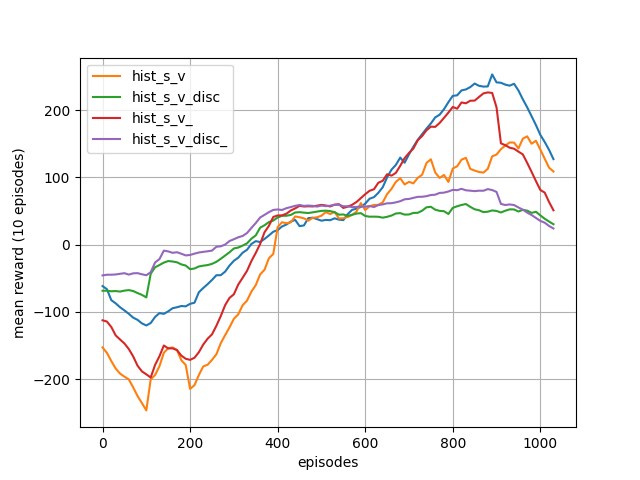

In [19]:
plt.grid(True)
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s[::10],np.ones(20)/20,mode='same'))
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s_v,np.ones(20)/20,mode='same'),label='hist_s_v')
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s_v_disc,np.ones(20)/20,mode='same'),label='hist_s_v_disc')
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s_v_,np.ones(20)/20,mode='same'),label='hist_s_v_')
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s_v_disc_,np.ones(20)/20,mode='same'),label='hist_s_v_disc_')
plt.xlabel('episodes')
plt.ylabel('mean reward (10 episodes)')
plt.legend()

In [15]:
plt.savefig('s_0.03e_0.005_false_128_0.03_0.993_500.png',dpi = 300, bbox_inches='tight', facecolor='w')

In [174]:
for target_param, local_param in zip(agent_s.q_function_.parameters(), agent_s.q_function.parameters()):
    print(torch.max((target_param-local_param)/target_param),torch.max((target_param-local_param)/local_param))

tensor(0.6526, grad_fn=<MaxBackward1>) tensor(1.8782, grad_fn=<MaxBackward1>)
tensor(0.1711, grad_fn=<MaxBackward1>) tensor(0.2064, grad_fn=<MaxBackward1>)
tensor(31.8134, grad_fn=<MaxBackward1>) tensor(1.5412, grad_fn=<MaxBackward1>)
tensor(0.2741, grad_fn=<MaxBackward1>) tensor(0.3776, grad_fn=<MaxBackward1>)
tensor(0.0166, grad_fn=<MaxBackward1>) tensor(0.0169, grad_fn=<MaxBackward1>)
tensor(-0.0004, grad_fn=<MaxBackward1>) tensor(-0.0004, grad_fn=<MaxBackward1>)


In [236]:
#env = gym.make('LunarLander-v2')
agent_s.epsilon = 0
total_reward = 0
state = env.reset()
for t in range(t_max):
    action = agent_s.get_action([state],True)
    next_state, reward, done, _ = env.step(action[0])
    env.render()
    total_reward += reward
    state = next_state
    if done:
        break
print(total_reward)

-44.65895993981232


<IPython.core.display.Javascript object>


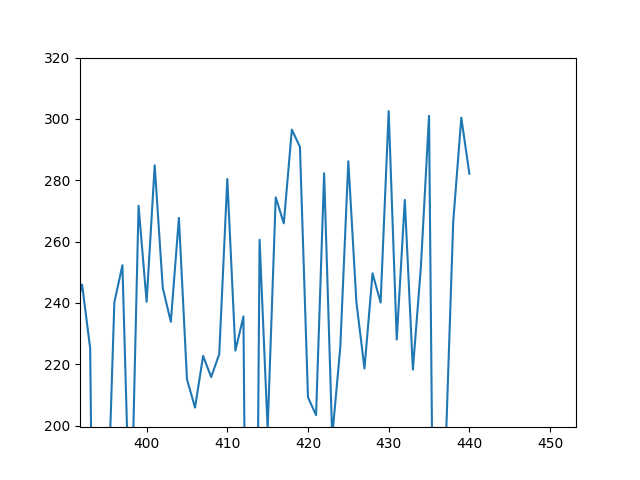

In [224]:
plt.plot(hist_s)

In [6]:
env = gym.make('LunarLander-v2')

In [28]:
class DDQN:
    def __init__(self, state_dim, action_dim, gamma=0.993, lr=1e-3, batch_size=128, epsilon_decrease=0.01, epsilon_min=0.05):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.q_function = Qfunction(self.state_dim, self.action_dim)
        self.q_function_ = Qfunction(self.state_dim, self.action_dim)
        for target_param in self.q_function_.parameters():
            target_param.data.copy_(target_param.data*0)
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = 1
        self.epsilon_decrease = epsilon_decrease
        self.epsilon_min = epsilon_min
        self.memory = []
        self.memory_lim = 150000
        self.optimzaer = torch.optim.Adam(self.q_function.parameters(), lr=lr)

    def get_action(self, state, target = False):
        if(target):
            q_values = self.q_function_(torch.FloatTensor(state))
        else:
            q_values = self.q_function(torch.FloatTensor(state))
        argmax_action = torch.argmax(q_values,dim=-1)
        probs = self.epsilon * np.ones((argmax_action.shape[0],self.action_dim)) / self.action_dim
        probs[np.arange(argmax_action.shape[0]),argmax_action] += 1 - self.epsilon
        action = np.ones(q_values.shape[0], dtype=np.int32)
        for sample in range(q_values.shape[0]):
            action[sample] = np.random.choice(np.arange(self.action_dim), p=probs[sample,:])
        return action
    
    def fit(self, state, action, reward, done, next_state, tau):
        self.memory.append([state, action, reward, int(done), next_state])
        if(len(self.memory)>self.memory_lim):
            self.memory = self.memory[int(self.memory_lim*0.05):]
            self.memory = random.sample(self.memory, int(self.memory_lim*0.9))
            print('clear memory')
        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.tensor, list(zip(*batch)))
            targets = rewards + self.gamma * (1 - dones) * (self.q_function(next_states)[np.arange(self.batch_size),torch.argmax(self.q_function_(next_states), dim=1)])
            q_values = self.q_function(states)[torch.arange(self.batch_size), actions]
            
            loss = torch.mean((q_values - targets.detach()) ** 2)
            loss.backward()
            self.optimzaer.step()
            self.optimzaer.zero_grad()
            
            self.soft_update(self.q_function,self.q_function_, tau)
            
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decrease
                
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [29]:
%%time
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

episode_n = 2000
t_max = 500
do_clear = True

agent_d = DDQN(state_dim, action_dim,epsilon_decrease=0.3/episode_n)
hist_d = []
hist_d_v = []
hist_d_v_disc = []
hist_d_v_ = []
hist_d_v_disc_ = []

for episode in range(episode_n):
    total_reward = 0

    state = env.reset()
    
    if(episode%2 == 1):
        eps = agent_d.epsilon
        agent_d.epsilon = 0
    for t in range(t_max):
        action = agent_d.get_action([state])
        next_state, reward, done, _ = env.step(action[0])

        total_reward += reward
        agent_d.fit(state, int(action), reward, done, next_state,tau = 0.005)

        state = next_state

        if done:
            break
    if(episode%2 == 1):
        agent_d.epsilon = eps
    
    
    hist_d.append(total_reward)
    
    #validate
    if(episode%10 == 0):
        eps = agent_d.epsilon
        agent_d.epsilon = 0
        total_reward = 0
        total_reward_disc = 0
        rew_mult = 1
        state = env.reset()
        for t in range(t_max):
            action = agent_d.get_action([state], True)
            next_state, reward, done, _ = env.step(action[0])

            total_reward += reward
            
            total_reward_disc += rew_mult*reward
            rew_mult *= agent_d.gamma

            state = next_state

            if done:
                break
        agent_d.epsilon = eps
        
        hist_d_v_.append(total_reward)
        hist_d_v_disc_.append(total_reward_disc)
        
    
    if(episode%10 == 0):
        eps = agent_d.epsilon
        agent_d.epsilon = 0
        total_reward = 0
        total_reward_disc = 0
        rew_mult = 1
        state = env.reset()
        for t in range(t_max):
            action = agent_d.get_action([state], False)
            next_state, reward, done, _ = env.step(action[0])

            total_reward += reward
            
            total_reward_disc += rew_mult*reward
            rew_mult *= agent_d.gamma

            state = next_state

            if done:
                break
        agent_d.epsilon = eps
        
        hist_d_v.append(total_reward)
        hist_d_v_disc.append(total_reward_disc)
        
    if(np.mean(hist_d_v[-10:])>220 and np.mean(hist_d_v_[-10:])>220):
        break
    if(np.mean(hist_d_v[-10:])>240 or np.mean(hist_d_v_[-10:])>240):
        break

    print(f'episode: {episode}, \
rew: {round(np.mean(hist_d[-100:]),2)}, \
v_: {round(np.mean(hist_d_v_[-10:]),2)}, \
v_disc_: {round(np.mean(hist_d_v_disc_[-10:]),2)}, \
v: {round(np.mean(hist_d_v[-10:]),2)}, \
v_disc: {round(np.mean(hist_d_v_disc[-10:]),2)}, \
epsilon: {round(agent_d.epsilon,2)}, \
mem: {len(agent_d.memory)}')

episode: 0, rew: -95.39, v_: -132.68, v_disc_: -97.95, v: -869.78, v_disc: -608.85, epsilon: 1, mem: 75
episode: 1, rew: -209.22, v_: -132.68, v_disc_: -97.95, v: -869.78, v_disc: -608.85, epsilon: 1, mem: 162
episode: 2, rew: -223.11, v_: -132.68, v_disc_: -97.95, v: -869.78, v_disc: -608.85, epsilon: 0.98, mem: 268
episode: 3, rew: -271.78, v_: -132.68, v_disc_: -97.95, v: -869.78, v_disc: -608.85, epsilon: 0.98, mem: 503
episode: 4, rew: -237.43, v_: -132.68, v_disc_: -97.95, v: -869.78, v_disc: -608.85, epsilon: 0.97, mem: 564
episode: 5, rew: -237.25, v_: -132.68, v_disc_: -97.95, v: -869.78, v_disc: -608.85, epsilon: 0.97, mem: 736
episode: 6, rew: -218.37, v_: -132.68, v_disc_: -97.95, v: -869.78, v_disc: -608.85, epsilon: 0.96, mem: 851
episode: 7, rew: -254.76, v_: -132.68, v_disc_: -97.95, v: -869.78, v_disc: -608.85, epsilon: 0.96, mem: 948
episode: 8, rew: -252.41, v_: -132.68, v_disc_: -97.95, v: -869.78, v_disc: -608.85, epsilon: 0.95, mem: 1031
episode: 9, rew: -265.46, 

episode: 74, rew: -96.29, v_: -165.36, v_disc_: -49.38, v: -157.0, v_disc: -85.56, epsilon: 0.19, mem: 18535
episode: 75, rew: -95.22, v_: -165.36, v_disc_: -49.38, v: -157.0, v_disc: -85.56, epsilon: 0.19, mem: 19035
episode: 76, rew: -93.85, v_: -165.36, v_disc_: -49.38, v: -157.0, v_disc: -85.56, epsilon: 0.12, mem: 19535
episode: 77, rew: -92.54, v_: -165.36, v_disc_: -49.38, v: -157.0, v_disc: -85.56, epsilon: 0.12, mem: 20035
episode: 78, rew: -90.81, v_: -165.36, v_disc_: -49.38, v: -157.0, v_disc: -85.56, epsilon: 0.05, mem: 20535
episode: 79, rew: -88.56, v_: -165.36, v_disc_: -49.38, v: -157.0, v_disc: -85.56, epsilon: 0.05, mem: 21035
episode: 80, rew: -87.16, v_: -148.79, v_disc_: -43.13, v: -154.93, v_disc: -74.9, epsilon: 0.05, mem: 21535
episode: 81, rew: -85.51, v_: -148.79, v_disc_: -43.13, v: -154.93, v_disc: -74.9, epsilon: 0.05, mem: 22035
episode: 82, rew: -84.12, v_: -148.79, v_disc_: -43.13, v: -154.93, v_disc: -74.9, epsilon: 0.05, mem: 22535
episode: 83, rew: -

episode: 152, rew: -3.38, v_: 12.89, v_disc_: 27.02, v: 15.35, v_disc: 28.47, epsilon: 0.05, mem: 56531
episode: 153, rew: -2.86, v_: 12.89, v_disc_: 27.02, v: 15.35, v_disc: 28.47, epsilon: 0.05, mem: 57031
episode: 154, rew: -2.4, v_: 12.89, v_disc_: 27.02, v: 15.35, v_disc: 28.47, epsilon: 0.05, mem: 57531
episode: 155, rew: -2.25, v_: 12.89, v_disc_: 27.02, v: 15.35, v_disc: 28.47, epsilon: 0.05, mem: 58031
episode: 156, rew: -3.33, v_: 12.89, v_disc_: 27.02, v: 15.35, v_disc: 28.47, epsilon: 0.05, mem: 58355
episode: 157, rew: -3.93, v_: 12.89, v_disc_: 27.02, v: 15.35, v_disc: 28.47, epsilon: 0.05, mem: 58855
episode: 158, rew: -3.63, v_: 12.89, v_disc_: 27.02, v: 15.35, v_disc: 28.47, epsilon: 0.05, mem: 59355
episode: 159, rew: -3.39, v_: 12.89, v_disc_: 27.02, v: 15.35, v_disc: 28.47, epsilon: 0.05, mem: 59855
episode: 160, rew: -3.06, v_: 17.0, v_disc_: 30.63, v: 10.59, v_disc: 27.82, epsilon: 0.05, mem: 60355
episode: 161, rew: -3.55, v_: 17.0, v_disc_: 30.63, v: 10.59, v_di

episode: 232, rew: -13.96, v_: 13.03, v_disc_: 28.4, v: -8.99, v_disc: 29.34, epsilon: 0.05, mem: 95670
episode: 233, rew: -13.93, v_: 13.03, v_disc_: 28.4, v: -8.99, v_disc: 29.34, epsilon: 0.05, mem: 96170
episode: 234, rew: -14.85, v_: 13.03, v_disc_: 28.4, v: -8.99, v_disc: 29.34, epsilon: 0.05, mem: 96670
episode: 235, rew: -15.13, v_: 13.03, v_disc_: 28.4, v: -8.99, v_disc: 29.34, epsilon: 0.05, mem: 97170
episode: 236, rew: -15.67, v_: 13.03, v_disc_: 28.4, v: -8.99, v_disc: 29.34, epsilon: 0.05, mem: 97670
episode: 237, rew: -15.45, v_: 13.03, v_disc_: 28.4, v: -8.99, v_disc: 29.34, epsilon: 0.05, mem: 98170
episode: 238, rew: -15.56, v_: 13.03, v_disc_: 28.4, v: -8.99, v_disc: 29.34, epsilon: 0.05, mem: 98670
episode: 239, rew: -15.74, v_: 13.03, v_disc_: 28.4, v: -8.99, v_disc: 29.34, epsilon: 0.05, mem: 99170
episode: 240, rew: -15.92, v_: 14.2, v_disc_: 27.85, v: -16.58, v_disc: 32.35, epsilon: 0.05, mem: 99670
episode: 241, rew: -16.04, v_: 14.2, v_disc_: 27.85, v: -16.58,

episode: 311, rew: 4.42, v_: 17.94, v_disc_: 32.42, v: 9.77, v_disc: 34.93, epsilon: 0.05, mem: 134376
episode: 312, rew: 4.09, v_: 17.94, v_disc_: 32.42, v: 9.77, v_disc: 34.93, epsilon: 0.05, mem: 134876
episode: 313, rew: 5.5, v_: 17.94, v_disc_: 32.42, v: 9.77, v_disc: 34.93, epsilon: 0.05, mem: 135376
episode: 314, rew: 6.22, v_: 17.94, v_disc_: 32.42, v: 9.77, v_disc: 34.93, epsilon: 0.05, mem: 135876
episode: 315, rew: 7.41, v_: 17.94, v_disc_: 32.42, v: 9.77, v_disc: 34.93, epsilon: 0.05, mem: 136376
episode: 316, rew: 6.55, v_: 17.94, v_disc_: 32.42, v: 9.77, v_disc: 34.93, epsilon: 0.05, mem: 136876
episode: 317, rew: 4.94, v_: 17.94, v_disc_: 32.42, v: 9.77, v_disc: 34.93, epsilon: 0.05, mem: 137376
episode: 318, rew: 4.93, v_: 17.94, v_disc_: 32.42, v: 9.77, v_disc: 34.93, epsilon: 0.05, mem: 137876
episode: 319, rew: 4.78, v_: 17.94, v_disc_: 32.42, v: 9.77, v_disc: 34.93, epsilon: 0.05, mem: 138376
episode: 320, rew: 5.52, v_: 19.36, v_disc_: 32.76, v: 15.34, v_disc: 37.7

episode: 390, rew: 14.2, v_: 30.64, v_disc_: 32.93, v: 36.45, v_disc: 27.55, epsilon: 0.05, mem: 139739
episode: 391, rew: 14.42, v_: 30.64, v_disc_: 32.93, v: 36.45, v_disc: 27.55, epsilon: 0.05, mem: 140239
episode: 392, rew: 14.2, v_: 30.64, v_disc_: 32.93, v: 36.45, v_disc: 27.55, epsilon: 0.05, mem: 140739
episode: 393, rew: 12.57, v_: 30.64, v_disc_: 32.93, v: 36.45, v_disc: 27.55, epsilon: 0.05, mem: 140839
episode: 394, rew: 12.69, v_: 30.64, v_disc_: 32.93, v: 36.45, v_disc: 27.55, epsilon: 0.05, mem: 141339
episode: 395, rew: 13.16, v_: 30.64, v_disc_: 32.93, v: 36.45, v_disc: 27.55, epsilon: 0.05, mem: 141839
episode: 396, rew: 13.95, v_: 30.64, v_disc_: 32.93, v: 36.45, v_disc: 27.55, epsilon: 0.05, mem: 142339
episode: 397, rew: 14.09, v_: 30.64, v_disc_: 32.93, v: 36.45, v_disc: 27.55, epsilon: 0.05, mem: 142839
episode: 398, rew: 13.96, v_: 30.64, v_disc_: 32.93, v: 36.45, v_disc: 27.55, epsilon: 0.05, mem: 143339
episode: 399, rew: 13.76, v_: 30.64, v_disc_: 32.93, v: 3

episode: 469, rew: 44.92, v_: 89.19, v_disc_: 49.25, v: -7.97, v_disc: 0.36, epsilon: 0.05, mem: 144002
episode: 470, rew: 43.57, v_: 104.98, v_disc_: 49.94, v: -17.55, v_disc: 1.9, epsilon: 0.05, mem: 144502
episode: 471, rew: 45.2, v_: 104.98, v_disc_: 49.94, v: -17.55, v_disc: 1.9, epsilon: 0.05, mem: 145002
episode: 472, rew: 43.56, v_: 104.98, v_disc_: 49.94, v: -17.55, v_disc: 1.9, epsilon: 0.05, mem: 145405
episode: 473, rew: 44.53, v_: 104.98, v_disc_: 49.94, v: -17.55, v_disc: 1.9, epsilon: 0.05, mem: 145905
episode: 474, rew: 46.37, v_: 104.98, v_disc_: 49.94, v: -17.55, v_disc: 1.9, epsilon: 0.05, mem: 146261
episode: 475, rew: 51.54, v_: 104.98, v_disc_: 49.94, v: -17.55, v_disc: 1.9, epsilon: 0.05, mem: 146713
episode: 476, rew: 51.82, v_: 104.98, v_disc_: 49.94, v: -17.55, v_disc: 1.9, epsilon: 0.05, mem: 147213
episode: 477, rew: 52.28, v_: 104.98, v_disc_: 49.94, v: -17.55, v_disc: 1.9, epsilon: 0.05, mem: 147620
episode: 478, rew: 51.95, v_: 104.98, v_disc_: 49.94, v: 

episode: 547, rew: 118.84, v_: 168.46, v_disc_: 59.1, v: 62.43, v_disc: 32.11, epsilon: 0.05, mem: 145736
episode: 548, rew: 120.92, v_: 168.46, v_disc_: 59.1, v: 62.43, v_disc: 32.11, epsilon: 0.05, mem: 146236
episode: 549, rew: 121.15, v_: 168.46, v_disc_: 59.1, v: 62.43, v_disc: 32.11, epsilon: 0.05, mem: 146736
episode: 550, rew: 121.42, v_: 161.8, v_disc_: 56.63, v: 81.37, v_disc: 36.25, epsilon: 0.05, mem: 147236
episode: 551, rew: 120.45, v_: 161.8, v_disc_: 56.63, v: 81.37, v_disc: 36.25, epsilon: 0.05, mem: 147736
episode: 552, rew: 118.47, v_: 161.8, v_disc_: 56.63, v: 81.37, v_disc: 36.25, epsilon: 0.05, mem: 148236
episode: 553, rew: 118.36, v_: 161.8, v_disc_: 56.63, v: 81.37, v_disc: 36.25, epsilon: 0.05, mem: 148698
episode: 554, rew: 113.71, v_: 161.8, v_disc_: 56.63, v: 81.37, v_disc: 36.25, epsilon: 0.05, mem: 148944
episode: 555, rew: 113.84, v_: 161.8, v_disc_: 56.63, v: 81.37, v_disc: 36.25, epsilon: 0.05, mem: 149284
episode: 556, rew: 114.55, v_: 161.8, v_disc_:

episode: 625, rew: 115.53, v_: 97.62, v_disc_: 29.3, v: 16.53, v_disc: -1.63, epsilon: 0.05, mem: 148245
episode: 626, rew: 117.74, v_: 97.62, v_disc_: 29.3, v: 16.53, v_disc: -1.63, epsilon: 0.05, mem: 148745
episode: 627, rew: 118.92, v_: 97.62, v_disc_: 29.3, v: 16.53, v_disc: -1.63, epsilon: 0.05, mem: 149039
episode: 628, rew: 116.6, v_: 97.62, v_disc_: 29.3, v: 16.53, v_disc: -1.63, epsilon: 0.05, mem: 149185
episode: 629, rew: 114.92, v_: 97.62, v_disc_: 29.3, v: 16.53, v_disc: -1.63, epsilon: 0.05, mem: 149685
clear memory
episode: 630, rew: 111.8, v_: 85.66, v_disc_: 25.94, v: 8.68, v_disc: 3.75, epsilon: 0.05, mem: 135184
episode: 631, rew: 109.96, v_: 85.66, v_disc_: 25.94, v: 8.68, v_disc: 3.75, epsilon: 0.05, mem: 135684
episode: 632, rew: 110.96, v_: 85.66, v_disc_: 25.94, v: 8.68, v_disc: 3.75, epsilon: 0.05, mem: 136156
episode: 633, rew: 111.28, v_: 85.66, v_disc_: 25.94, v: 8.68, v_disc: 3.75, epsilon: 0.05, mem: 136496
episode: 634, rew: 113.82, v_: 85.66, v_disc_: 2

episode: 703, rew: 108.59, v_: 129.42, v_disc_: 41.43, v: 61.0, v_disc: 28.72, epsilon: 0.05, mem: 135564
episode: 704, rew: 106.74, v_: 129.42, v_disc_: 41.43, v: 61.0, v_disc: 28.72, epsilon: 0.05, mem: 136064
episode: 705, rew: 105.65, v_: 129.42, v_disc_: 41.43, v: 61.0, v_disc: 28.72, epsilon: 0.05, mem: 136564
episode: 706, rew: 105.58, v_: 129.42, v_disc_: 41.43, v: 61.0, v_disc: 28.72, epsilon: 0.05, mem: 137064
episode: 707, rew: 104.03, v_: 129.42, v_disc_: 41.43, v: 61.0, v_disc: 28.72, epsilon: 0.05, mem: 137564
episode: 708, rew: 102.81, v_: 129.42, v_disc_: 41.43, v: 61.0, v_disc: 28.72, epsilon: 0.05, mem: 138064
episode: 709, rew: 102.38, v_: 129.42, v_disc_: 41.43, v: 61.0, v_disc: 28.72, epsilon: 0.05, mem: 138564
episode: 710, rew: 102.85, v_: 148.1, v_disc_: 52.31, v: 54.56, v_disc: 27.47, epsilon: 0.05, mem: 139064
episode: 711, rew: 101.41, v_: 148.1, v_disc_: 52.31, v: 54.56, v_disc: 27.47, epsilon: 0.05, mem: 139564
episode: 712, rew: 101.58, v_: 148.1, v_disc_:

episode: 780, rew: 105.53, v_: 143.53, v_disc_: 50.8, v: 79.0, v_disc: 34.48, epsilon: 0.05, mem: 135859
episode: 781, rew: 106.24, v_: 143.53, v_disc_: 50.8, v: 79.0, v_disc: 34.48, epsilon: 0.05, mem: 136172
episode: 782, rew: 107.45, v_: 143.53, v_disc_: 50.8, v: 79.0, v_disc: 34.48, epsilon: 0.05, mem: 136672
episode: 783, rew: 107.49, v_: 143.53, v_disc_: 50.8, v: 79.0, v_disc: 34.48, epsilon: 0.05, mem: 137093
episode: 784, rew: 106.64, v_: 143.53, v_disc_: 50.8, v: 79.0, v_disc: 34.48, epsilon: 0.05, mem: 137593
episode: 785, rew: 104.15, v_: 143.53, v_disc_: 50.8, v: 79.0, v_disc: 34.48, epsilon: 0.05, mem: 138093
episode: 786, rew: 104.47, v_: 143.53, v_disc_: 50.8, v: 79.0, v_disc: 34.48, epsilon: 0.05, mem: 138438
episode: 787, rew: 103.83, v_: 143.53, v_disc_: 50.8, v: 79.0, v_disc: 34.48, epsilon: 0.05, mem: 138938
episode: 788, rew: 105.51, v_: 143.53, v_disc_: 50.8, v: 79.0, v_disc: 34.48, epsilon: 0.05, mem: 139294
episode: 789, rew: 105.57, v_: 143.53, v_disc_: 50.8, v

episode: 857, rew: 152.96, v_: 133.32, v_disc_: 58.2, v: 75.36, v_disc: 37.72, epsilon: 0.05, mem: 136273
episode: 858, rew: 151.82, v_: 133.32, v_disc_: 58.2, v: 75.36, v_disc: 37.72, epsilon: 0.05, mem: 136485
episode: 859, rew: 154.04, v_: 133.32, v_disc_: 58.2, v: 75.36, v_disc: 37.72, epsilon: 0.05, mem: 136762
episode: 860, rew: 155.57, v_: 134.7, v_disc_: 57.69, v: 72.04, v_disc: 39.42, epsilon: 0.05, mem: 137207
episode: 861, rew: 158.02, v_: 134.7, v_disc_: 57.69, v: 72.04, v_disc: 39.42, epsilon: 0.05, mem: 137501
episode: 862, rew: 159.45, v_: 134.7, v_disc_: 57.69, v: 72.04, v_disc: 39.42, epsilon: 0.05, mem: 137893
episode: 863, rew: 160.14, v_: 134.7, v_disc_: 57.69, v: 72.04, v_disc: 39.42, epsilon: 0.05, mem: 138393
episode: 864, rew: 162.32, v_: 134.7, v_disc_: 57.69, v: 72.04, v_disc: 39.42, epsilon: 0.05, mem: 138755
episode: 865, rew: 162.46, v_: 134.7, v_disc_: 57.69, v: 72.04, v_disc: 39.42, epsilon: 0.05, mem: 139076
episode: 866, rew: 162.51, v_: 134.7, v_disc_:

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


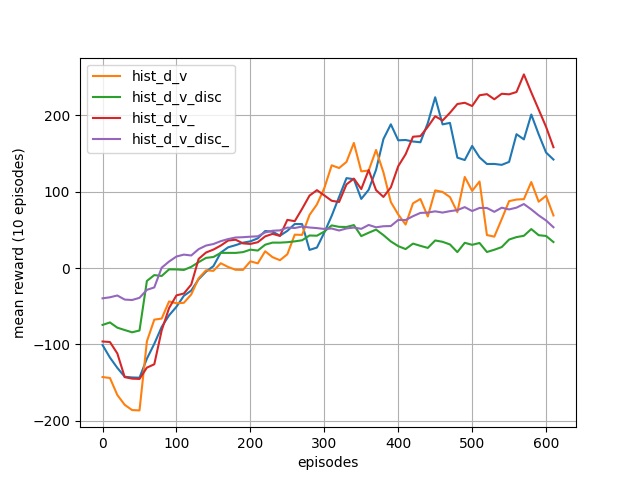

In [25]:
plt.grid(True)
plt.plot([i for i in range(0,len(hist_d[::10])*10,10)],np.convolve(hist_d[::10],np.ones(10)/10,mode='same'))
plt.plot([i for i in range(0,len(hist_d[::10])*10,10)],np.convolve(hist_d_v,np.ones(10)/10,mode='same'),label='hist_d_v')
plt.plot([i for i in range(0,len(hist_d[::10])*10,10)],np.convolve(hist_d_v_disc,np.ones(10)/10,mode='same'),label='hist_d_v_disc')
plt.plot([i for i in range(0,len(hist_d[::10])*10,10)],np.convolve(hist_d_v_,np.ones(10)/10,mode='same'),label='hist_d_v_')
plt.plot([i for i in range(0,len(hist_d[::10])*10,10)],np.convolve(hist_d_v_disc_,np.ones(10)/10,mode='same'),label='hist_d_v_disc_')
plt.xlabel('episodes')
plt.ylabel('mean reward (10 episodes)')
plt.legend()

In [223]:
#env = gym.make('LunarLander-v2')
agent_d.epsilon = 0.1
total_reward = 0
state = env.reset()
for t in range(t_max//2):
    action = agent_d.get_action([state], True)
    next_state, reward, done, _ = env.step(action[0])
    env.render()
    total_reward += reward
    state = next_state
    if done:
        break
print(total_reward)

-558.2730384799879


In [200]:
for target_param, local_param in zip(agent_d.q_function_.parameters(), agent_d.q_function.parameters()):
    print(torch.max((target_param-local_param)/target_param),torch.max((target_param-local_param)/local_param))

tensor(0.9472, grad_fn=<MaxBackward1>) tensor(17.9465, grad_fn=<MaxBackward1>)
tensor(0.2104, grad_fn=<MaxBackward1>) tensor(0.2664, grad_fn=<MaxBackward1>)
tensor(2.2514, grad_fn=<MaxBackward1>) tensor(2.0815, grad_fn=<MaxBackward1>)
tensor(0.7409, grad_fn=<MaxBackward1>) tensor(2.8591, grad_fn=<MaxBackward1>)
tensor(0.0214, grad_fn=<MaxBackward1>) tensor(0.0219, grad_fn=<MaxBackward1>)
tensor(-0.0011, grad_fn=<MaxBackward1>) tensor(-0.0011, grad_fn=<MaxBackward1>)


In [16]:
def picc(vx=0,vy=0,f=0,w=0,l=0,r=0):
    pic = np.zeros((300,300,3))
    pic_w = np.zeros((300,300,3))
    obs = np.zeros((300*300,8))
    for x in range(300):
        for y in range(300):
            obs[x*300+y] = np.array([-1.5+x/100,1.5-y/100,vx,vy,f,w,l,r])
    act_flat = agent.get_action(obs)
    actions = np.zeros((300,300),dtype=np.int32)
    for x in range(300):
        for y in range(300):
            actions[x,y] = act_flat[x*300+y]
            
    max_actions = actions
    for x in range(300):
        for y in range(300):
            if max_actions[x,y]>0:
                pic[x,y,max_actions[x,y]-1] = 1
                
    fig = plt.figure(figsize=(5,10))
    ax = plt.subplot(211)
    ax.imshow(pic_w)
    rect = patches.Rectangle((150-20, 150-15), 40, 30, angle=-f/3.14*180, linewidth=1, edgecolor='b', facecolor='b')
    arrow = patches.Arrow(150, 150,vx*100,-vy*100, width=10,  edgecolor='red', facecolor='r')
    ax.add_patch(rect)
    ax.add_patch(arrow)
    plt.subplot(212)
    plt.imshow(pic.transpose(1,0,2))
    plt.savefig(f'visual/lunalender_vx{vx}_vy{vy}_f{f}.png',dpi=300, bbox_inches='tight',facecolor='white')

<IPython.core.display.Javascript object>


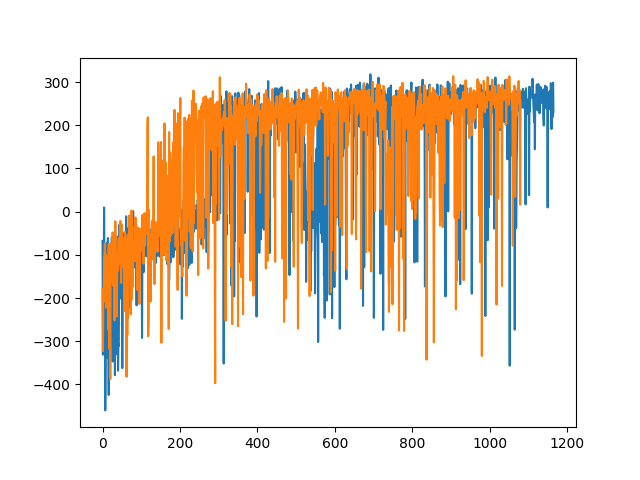

In [12]:
plt.plot(hist_s)
plt.plot(hist_d)

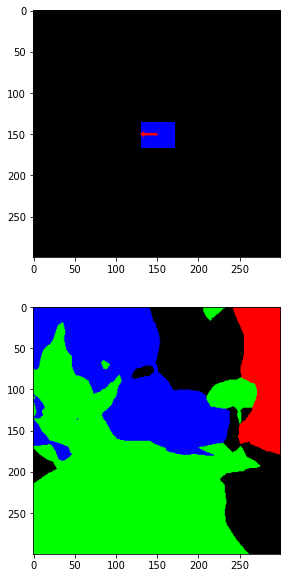

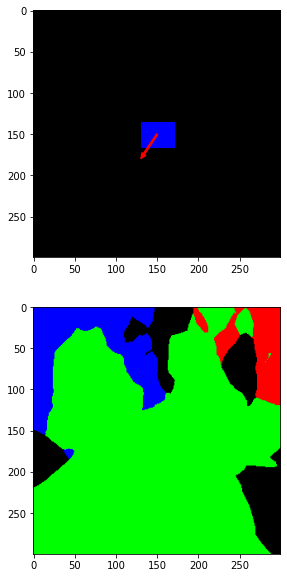

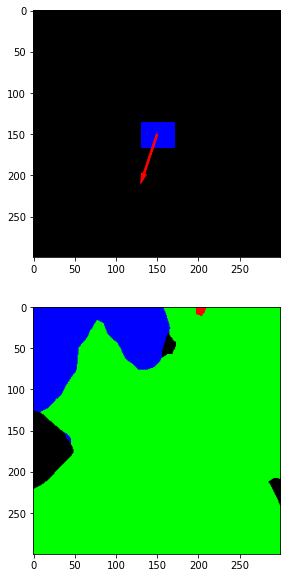

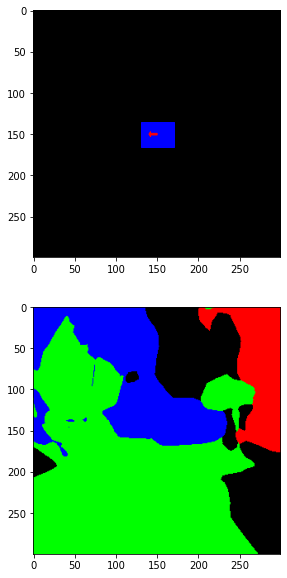

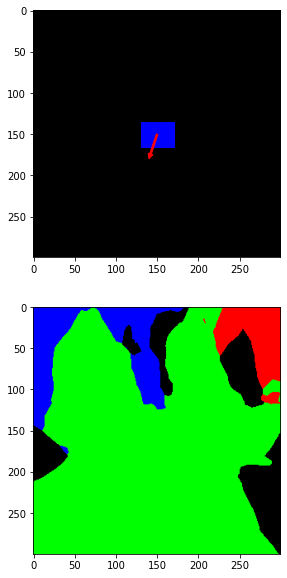

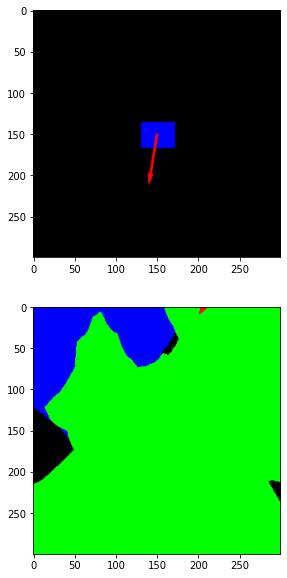

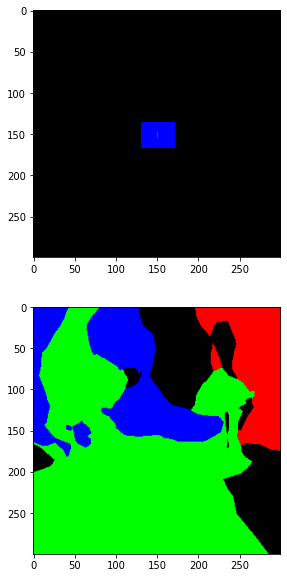

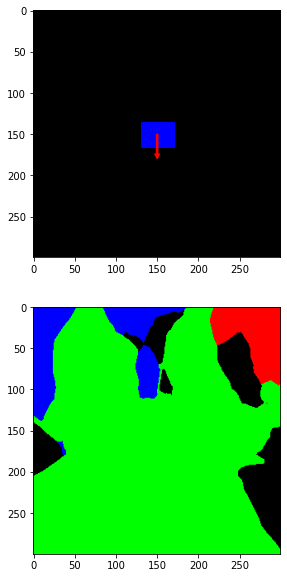

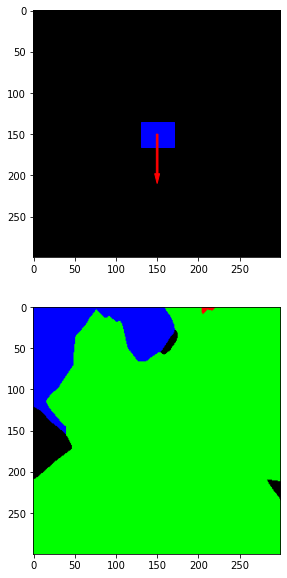

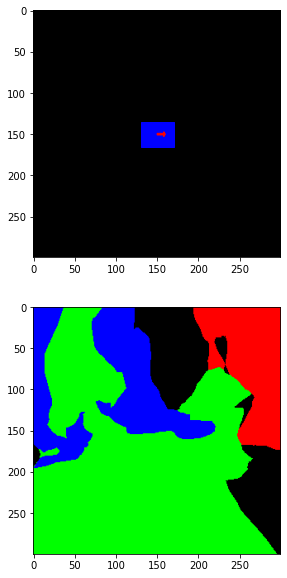

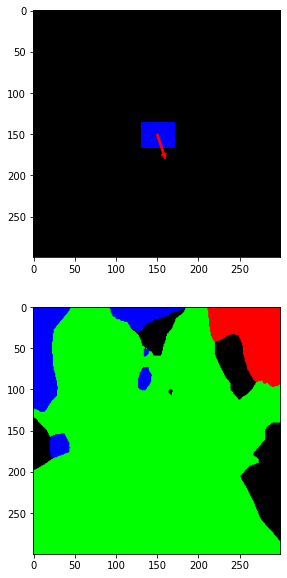

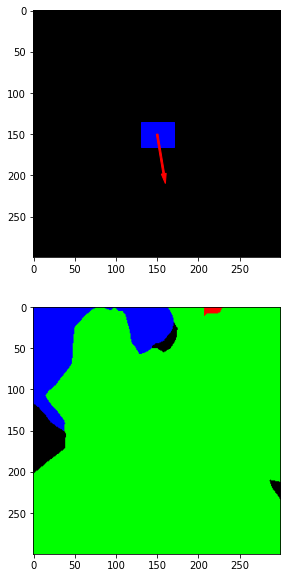

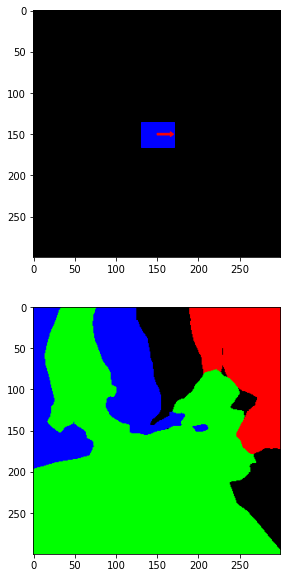

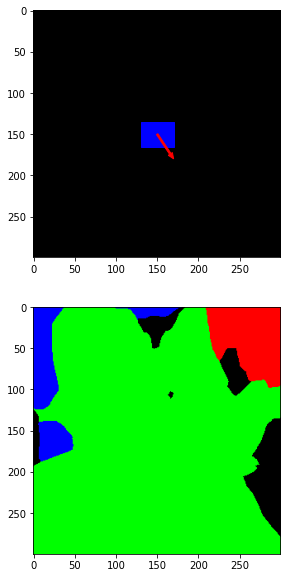

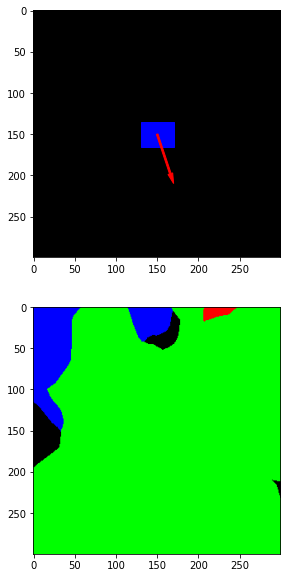

In [17]:
vx = [-0.2, -0.1, 0, 0.1 , 0.2]
vy = [0, -0.3, -0.6]
f = [0]
for i in range(5):
    for j in range(3):
        for k in range(1):
            picc(vx[i],vy[j],f[k])